In [243]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

### Загрузка данных

In [244]:
features=pd.read_csv('Features data set.csv')
sales=pd.read_csv('sales data-set.csv')
stores=pd.read_csv('stores data-set.csv')
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

In [245]:
features= features.assign(IsHoliday = [int(x) for x in list(features.IsHoliday)])
sales= sales.assign(IsHoliday = [int(x) for x in list(sales.IsHoliday)])

In [246]:
sales = sales.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()



In [247]:
sales = sales.sort('Date')

### Выбираем один магазин для которого будем строить модель и подготовливаем данные

In [248]:
sales=sales[sales['Store'] ==1]

In [249]:
sales.index = sales['Date']

In [250]:
df=pd.merge(sales,features, on=['Store','Date'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

In [251]:
df.index= df['Date']

In [252]:
df= df.resample('W', how='mean').interpolate(method='linear')

In [253]:
df_fu=df.iloc[-16:] # датафрейм для предсказания на 16 недель

In [254]:
import datetime as dt

In [255]:
df_fu.index = df_fu.index+dt.timedelta(weeks=16)

In [256]:
df = pd.concat([df, df_fu])

In [257]:
df= pd.DataFrame(df.copy())


#### Добавляем лаги, с началом в 16 недель, для дальнейщего предсказания

In [258]:
lag_start=16
lag_end=54
test_size=0.15

In [259]:
for i in range(lag_start, lag_end):
        df["lag_{}".format(i)] = df.Weekly_Sales.shift(i)

In [260]:
df = df.assign(year = df.index.year)
df = df.assign(week = df.index.week)


In [261]:
df['MarkDown1'].fillna(value = 0, inplace=True)
df['MarkDown2'].fillna(value = 0, inplace=True)
df['MarkDown3'].fillna(value = 0, inplace=True)
df['MarkDown4'].fillna(value = 0, inplace=True)
df['MarkDown5'].fillna(value = 0, inplace=True)

In [262]:
df = df.dropna()
# df = df.reset_index(drop=True)

In [263]:
df_fu= df.iloc[-16:]
df= df.iloc[:-16]

In [264]:
df_fu = df_fu.drop(["Weekly_Sales"], axis=1)

### Строим модель - линейная регрессия 

In [265]:
test_index = int(len(df)*(1-test_size))

In [266]:
X_train = df.iloc[:test_index].drop(["Weekly_Sales"], axis=1)
y_train = df.iloc[:test_index]["Weekly_Sales"]
X_test = df.iloc[test_index:].drop(["Weekly_Sales"], axis=1)
y_test = df.iloc[test_index:]["Weekly_Sales"]

#### Без валидации

In [267]:
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [268]:
prediction = lr.predict(X_test)


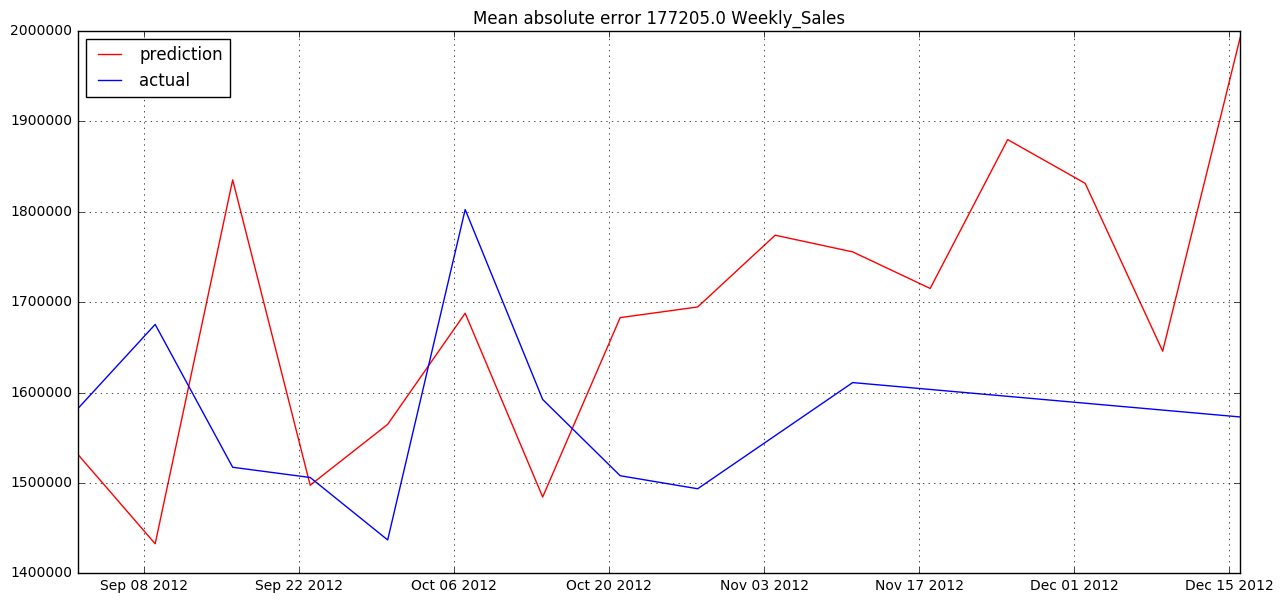

In [269]:

plt.figure(figsize=(15, 7))
plt.plot(X_test.index, prediction, "r", label="prediction")
plt.plot(X_test.index, y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Mean absolute error {} Weekly_Sales".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

##### С валидацией.Функция для валидации взята с http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/

In [270]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 2):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors

In [271]:
%%time
lr1 = LinearRegression()
error = performTimeSeriesCV(X_train, y_train, 5, lr1, mean_absolute_error)

Size train set: (85, 52)
Size of each fold: 17

Splitting the first 2 chunks at 1/2
Size of train + test: (34, 52)

Splitting the first 3 chunks at 2/3
Size of train + test: (51, 52)

Splitting the first 4 chunks at 3/4
Size of train + test: (68, 52)

Splitting the first 5 chunks at 4/5
Size of train + test: (85, 52)

Splitting the first 6 chunks at 5/6
Size of train + test: (85, 52)
Wall time: 258 ms


In [272]:
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [273]:
prediction1 = lr1.predict(X_test)

In [274]:
mean_absolute_error(y_test, prediction, sample_weight=None) # Ошибка модели без валидации

177205.18156250007

In [275]:
error.mean() # С валидацией

11649716.207786214

In [276]:
error

array([   252516.63151043,    603790.58182608,  57106470.59530438,
          145554.03546875,    140249.19482143])

#### Предсказания на 16 недель вперед для магазина 1

In [277]:
prediction_fu = lr.predict(df_fu)

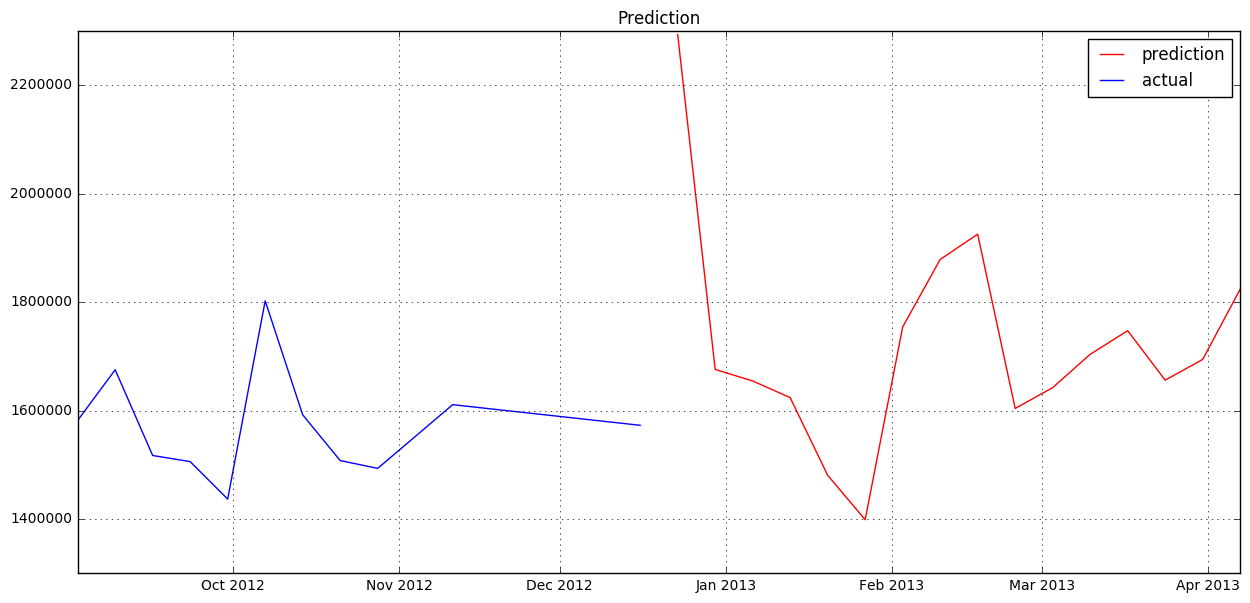

In [278]:
plt.figure(figsize=(15, 7))
plt.plot(df_fu.index, prediction_fu,  "r", label="prediction")
plt.plot(X_test.index, y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Prediction")
plt.grid(True);